# Aprendizado de Máquina
O objetivo desse trabalho é estudar técnicas de aprendizado supervisionado e não-supervisionado, mais especificamente os algoritmos k-Nearest Neighbors (kNN) e k-Means.

O trabalho é dividido em duas partes. Nas duas iremos utilizar o conjunto de dados NBA Rookie Stats, que contém estatísticas de jogadores novatos da NBA. Ele consiste de 1.340 observações, com as seguintes variáveis (atributos):
- GP: Total de jogos disputados
- MIN: Minutos jogados
- PTS: Pontos marcados por jogo
- FGM: Arremessos convertidos
- FGA: Tentativas de arremessos
- FG%: Percentual de conversão de arremessos
- 3PMade: Arremessos de 3 pontos convertidos
- 3PA: Tentativas de arremessos de 3 pontos
- 3P%: Percentual de conversão de arremessos de 3 pontos
- FTM: Lances livres convertidos
- FTA: Tentativas de lances livres
- FT%: Percentual de conversão de lances livres
- OREB: Rebotes ofensivos
- DREB: Rebotes defensivos
- REB: Total de rebotes
- AST: Assistências
- STL: Roubos de bola
- BLK: Bloqueios
- TOV: Perdas de bola
- TARGET_5Yrs: Se a carreira do jogador durou pelo menos 5 anos na liga, tem valor 1. Caso contrário, o valor é 0.
A variável TARGET_5Yrs é a variável resposta de interesse no uso deste conjunto de dados.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
# define random seed for reproductability
np.random.seed(42)

In [ ]:
# Loading the data
from google.colab import drive
drive.mount('/content/drive')

train = pd.read_csv('/content/drive/MyDrive/nba_treino.csv')
test  = pd.read_csv('/content/drive/MyDrive/nba_teste.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Visualize characteristic to make some project decisions later
train.describe()

,GP,MIN,PTS,FGM,FGA,FG%,3PMade,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
count,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000,1072.000000
mean,60.256530,17.750746,6.892257,2.663433,5.956903,44.166418,0.255317,0.797948,19.317631,1.312966,1.839832,70.468750,1.017724,2.060821,3.078265,1.539179,0.619216,0.371362,1.197575,0.618470
std,17.489665,8.427761,4.438254,1.717126,3.654107,6.103108,0.391804,1.079983,16.113005,1.000238,1.339798,10.497002,0.784790,1.393480,2.100763,1.449761,0.405384,0.438134,0.723691,0.485989
min,11.000000,3.100000,0.700000,0.300000,0.800000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.300000,0.000000,0.000000,0.000000,0.100000,0.000000
25%,47.000000,10.900000,3.700000,1.400000,3.300000,40.200000,0.000000,0.000000,0.000000,0.600000,0.900000,64.775000,0.400000,1.000000,1.500000,0.600000,0.300000,0.100000,0.700000,0.000000
50%,63.000000,16.100000,5.600000,2.100000,4.800000,43.900000,0.100000,0.300000,22.300000,1.000000,1.500000,71.350000,0.800000,1.700000,2.500000,1.100000,0.500000,0.200000,1.000000,1.000000
75%,77.000000,23.100000,8.900000,3.400000,7.600000,47.900000,0.400000,1.225000,32.700000,1.600000,2.300000,77.725000,1.400000,2.700000,4.000000,1.900000,0.800000,0.500000,1.500000,1.000000
max,82.000000,40.900000,28.200000,10.200000,19.800000,66.200000,2.300000,6.500000,100.000000,7.700000,10.200000,100.000000,5.300000,9.600000,13.900000,10.600000,2.500000,3.900000,4.200000,1.000000


In [ ]:
# Prepare the data
## Separate X and Y

Y_train = train['TARGET_5Yrs'].values
X_train = train.drop(columns=['TARGET_5Yrs']).values

Y_test = test['TARGET_5Yrs'].values
X_test = test.drop(columns=['TARGET_5Yrs']).values

## Normalize X to avoid scale problems

X_train = (X_train - X_train.mean()) / X_train.std()
X_test = (X_test - X_test.mean()) / X_test.std()

In [ ]:
# Common analyze utility for using on all tested models
def analyze(Y_pred, Y, show=False):

  # Values of each result categary
  true_positive  = np.sum((Y_pred == 1) & (Y == 1))
  true_negative  = np.sum((Y_pred == 0) & (Y == 0))
  false_positive = np.sum((Y_pred == 1) & (Y == 0))
  false_negative = np.sum((Y_pred == 0) & (Y == 1))

  # Calculate the scores
  accuracy = (true_positive + true_negative) / len(Y)
  precision = true_positive / (true_positive + false_positive)
  recall = true_positive / (true_positive + false_negative)
  f1 = 2 * precision * recall / (precision + recall)

  # Print results
  if show:
    print(f'Accuracy:\t {accuracy:.6}')
    print(f'Precision:\t {precision:.6}')
    print(f'Recall:\t\t {recall:.6}')
    print(f'F1-Score:\t {f1:.6}')

  return [ accuracy, precision, recall, f1 ]

In [ ]:
def stats_plot(stats, x, title='', xlabel=''):
  plt.figure(figsize=(16,8))

  plt.plot(x, stats[:,0], label='Accuracy')
  plt.plot(x, stats[:,1], label='Precision')
  plt.plot(x, stats[:,2], label='Recall')
  plt.plot(x, stats[:,3], label='F1')

  plt.title(title)
  plt.xlabel(xlabel)
  plt.legend()
  plt.ylim(0.0, 1.0)
  plt.show()

# Aprendizado Supervisionado
Na primeira parte do trabalho você deverá implementar o algoritmo **k-Nearest Neighbors** para classificar se a carreira de um jogador vai durar pelo menos 5 anos na liga ou não, utilizando os atributos. Você deve separar o conjunto de dados em 2 partes: 80% dos dados (1.072 observações) serão usados no conjunto de treino e 20% (268 observações) para o teste (utilize os arquivos
nba_treino.csv e nba_teste.csv). Teste o seu algoritmo com 4 valores de k diferentes (2, 10, 50 e outro valor a sua escolha) e, para cada um deles, classifique os dados do conjunto de teste, mostre a matriz de confusão obtida e compute os valores de acurácia, precisão, revocação (recall) e F1. Analise e discuta os resultados obtidos.

In [ ]:
class KNN:
  def __init__(self, k=3):
    self.k = k

  def fit(self, X, y):
    self.X_train = X
    self.y_train = y

  def predict(self, X):
    predictions = [self._predict(x) for x in X]
    return np.array(predictions)

  def _predict(self, x):
    # Compute distances between x and all examples in the training set
    distances = [np.linalg.norm(x - x_train) for x_train in self.X_train]

    # Get indices of k-nearest training data points
    k_indices = np.argsort(distances)[:self.k]

    # Since we are working with a binary Y, we just need to check the sum
    positive_support = sum([self.y_train[i] for i in k_indices])
    return 1 if positive_support >= self.k / 2 else 0

In [ ]:
# Test cases
K = [2, 10, 26, 50, 82, 122, 170]
for k in K:
  model = KNN(k)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)

  print(f'=================================')
  print(f'============== {k:3} ==============')
  print(f'=================================')
  analyze(Y_pred, Y_test, show=True)

==============   2 ==============
Accuracy:	 0.641791
Precision:	 0.666667
Recall:		 0.857143
F1-Score:	 0.75
==============  10 ==============
Accuracy:	 0.664179
Precision:	 0.705263
Recall:		 0.797619
F1-Score:	 0.748603
==============  26 ==============
Accuracy:	 0.675373
Precision:	 0.721311
Recall:		 0.785714
F1-Score:	 0.752137
==============  50 ==============
Accuracy:	 0.682836
Precision:	 0.731844
Recall:		 0.779762
F1-Score:	 0.755043
==============  82 ==============
Accuracy:	 0.675373
Precision:	 0.723757
Recall:		 0.779762
F1-Score:	 0.750716
============== 122 ==============
Accuracy:	 0.697761
Precision:	 0.737705
Recall:		 0.803571
F1-Score:	 0.769231
============== 170 ==============
Accuracy:	 0.671642
Precision:	 0.722222
Recall:		 0.77381
F1-Score:	 0.747126


Agora observaremos a evolução das estatisticas de sucesso do modelo conforme aumentamos o numero de vizinhos utilizados.

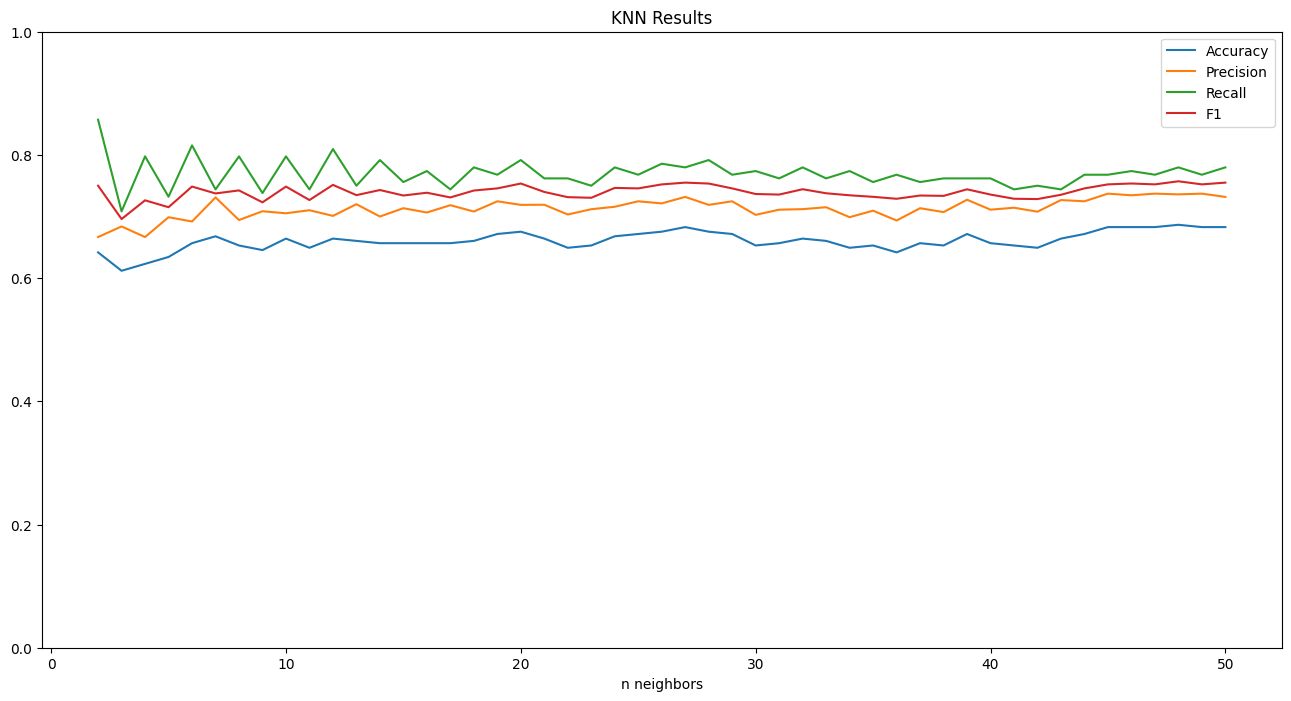

In [ ]:
n_neighbors = range(2,51)
iters = 10**4
stats = []
for k in n_neighbors:
  model = KNN(k)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)

  stats.append(analyze(Y_pred, Y_test))

stats = np.array(stats)
stats_plot(stats, n_neighbors, title='KNN Results', xlabel='n neighbors')

# Aprendizado Não Supervisionado
Na segunda parte você deverá implementar o algoritmo k-Means para agrupar os jogadores em
diferentes conjuntos (clusters) usando apenas os atributos das amostras (sem utilizar a coluna de
resposta TARGET_5Yrs). Teste o seu algoritmo com 2 valores de k diferentes (2 e 3), imprimindo o
valor obtido para os centróides de cada agrupamento. Além disso, verifique se existe alguma
relação entre os agrupamentos obtidos nos dois testes e os rótulos originais dos dados. Por
exemplo, com k igual a 2 o algoritmo conseguiu agrupar bem os jogadores nas duas classes de
resposta originais? O que acontece para k igual a 3? Analise e discuta os resultados obtidos.

In [ ]:
class KMeans:
  def __init__(self, n_clusters, max_iters=100):
    self.n_clusters = n_clusters
    self.max_iters = max_iters

  def fit(self, X):
    self.centroids = X[np.random.choice(X.shape[0], self.n_clusters, replace=False)]

    for _ in range(self.max_iters):
      # Assign each data point to the nearest centroid
      labels = self._assign_labels(X)

      # Update the centroids based on the mean of the assigned data points
      new_centroids = self._update_centroids(X, labels)

      # Check for convergence
      if np.all(self.centroids == new_centroids):
          break

      self.centroids = new_centroids

  def predict(self, X):
    return self._assign_labels(X)

  def _assign_labels(self, X):
    distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2)
    return np.argmin(distances, axis=1)

  def _update_centroids(self, X, labels):
    new_centroids = [X[labels == k].mean(axis=0) for k in range(self.n_clusters)]
    return np.array(new_centroids)

In [ ]:
def map_labels_to_Y(labels, Y):
  return [1 if Y[labels == k].mean() > 0.5 else 0 for k in range(max(labels) + 1)]

In [ ]:
# Test cases
n_clusters = [2, 3, 5]
iters = 10000
for n in n_clusters:

  print(f'================================')
  print(f'========== {n} clusters ==========')
  print(f'================================')

  model = KMeans(n, max_iters=iters)
  model.fit(X_train)

  print('\nCentroids\n')
  for c in model.centroids:
    print(c)
    print()

  print('How well the clusters represent the target?')

  labels = model.predict(X_train)
  map_labels = map_labels_to_Y(labels, Y_train)
  labels_test = model.predict(X_test)

  Y_pred = np.array([map_labels[k] for k in labels_test])

  analyze(Y_pred, Y_test, show=True)
  print()

========== 2 clusters ==========

Centroids

[ 2.77802579  0.45047796 -0.16203012 -0.4189366  -0.22494376  1.49128819
 -0.5652572  -0.53417439  0.42473277 -0.50040331 -0.47034907  2.7476287
 -0.52234594 -0.45958814 -0.40140431 -0.48603462 -0.54407819 -0.55898453
 -0.50986295]

[ 1.43882597 -0.03585528 -0.39097501 -0.50713093 -0.40932432  1.36974124
 -0.57324669 -0.55607182  0.15300261 -0.54491942 -0.52809217  2.50404422
 -0.54819843 -0.51880947 -0.48648913 -0.53946066 -0.56213188 -0.56912209
 -0.54513552]

How well the clusters represent the target?
Accuracy:	 0.645522
Precision:	 0.751724
Recall:		 0.64881
F1-Score:	 0.696486

========== 3 clusters ==========

Centroids

[ 2.26592498  0.16367695 -0.29781651 -0.46825871 -0.34916761  1.6107141
 -0.58050054 -0.57826681 -0.53186447 -0.52253464 -0.49296549  2.42535897
 -0.51816591 -0.47184996 -0.40934255 -0.53729453 -0.55779301 -0.55583078
 -0.53103762]

[ 2.77470604  0.47365272 -0.14776697 -0.41493415 -0.2047878   1.4173729
 -0.55890468 -

Agora observaremos a evolução das estatisticas de sucesso do modelo conforme aumentamos o numero de centroides utilizados.

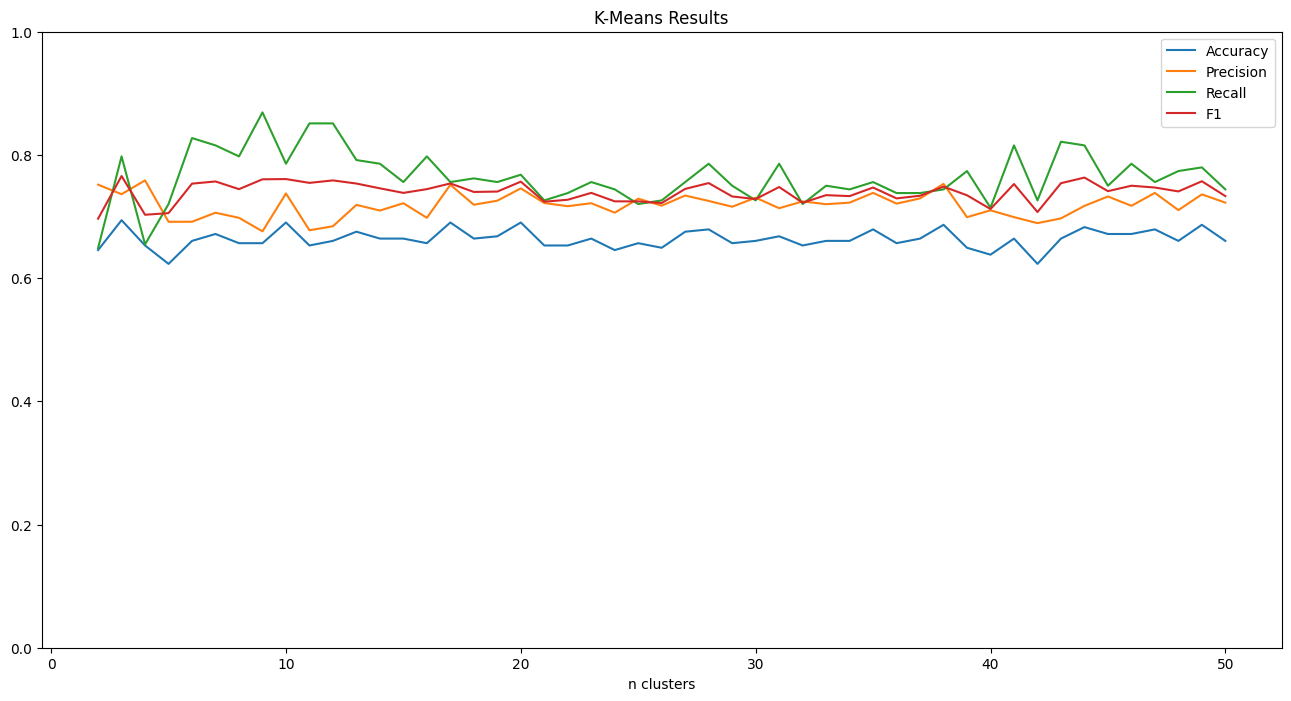

In [ ]:
n_clusters = range(2,51)
iters = 10**4
stats = []
for k in n_clusters:
  model = KMeans(k, max_iters=iters)
  model.fit(X_train)
  labels = model.predict(X_train)
  mapped_labels = map_labels_to_Y(labels, Y_train)
  labels_test = model.predict(X_test)
  Y_pred = np.array([mapped_labels[k] for k in labels_test])

  stats.append(analyze(Y_pred, Y_test))

stats = np.array(stats)
stats_plot(stats, n_clusters, title='K-Means Results', xlabel='n clusters')

# Extras
Vamos comparar a qualidade dos modelos desenvolvidos com os modelos implementados por sklearn

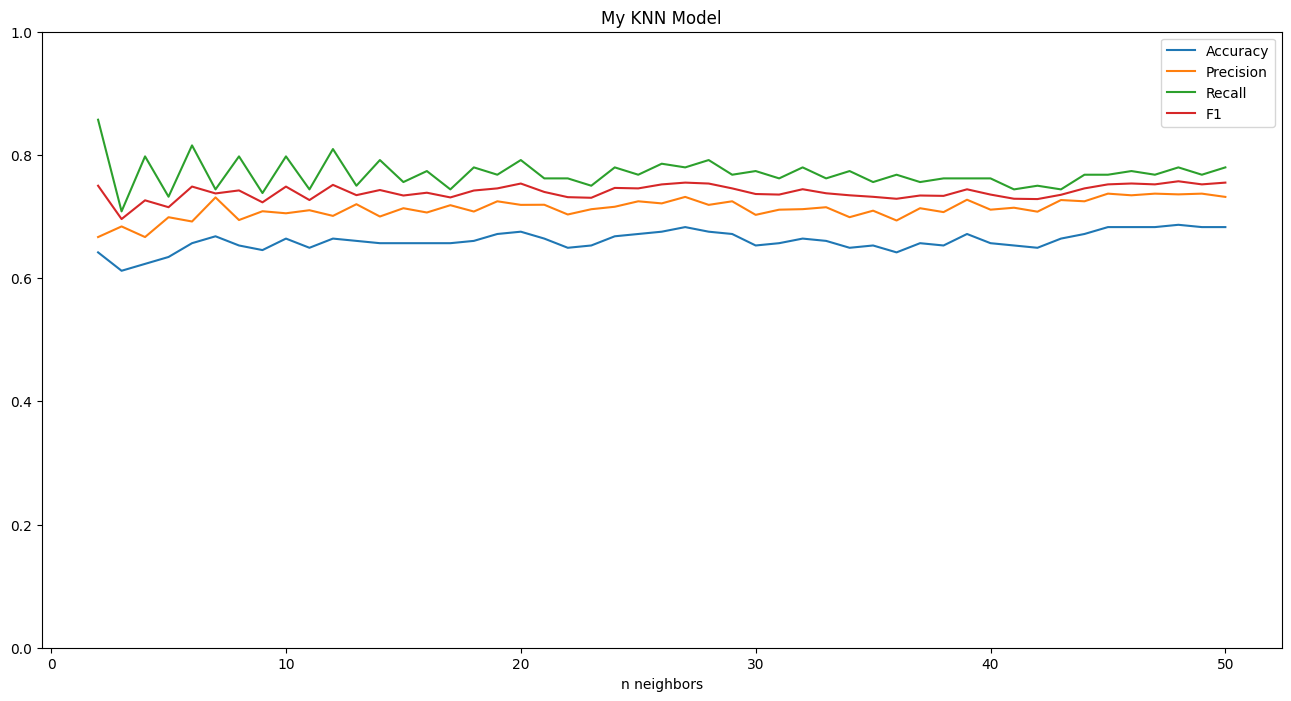

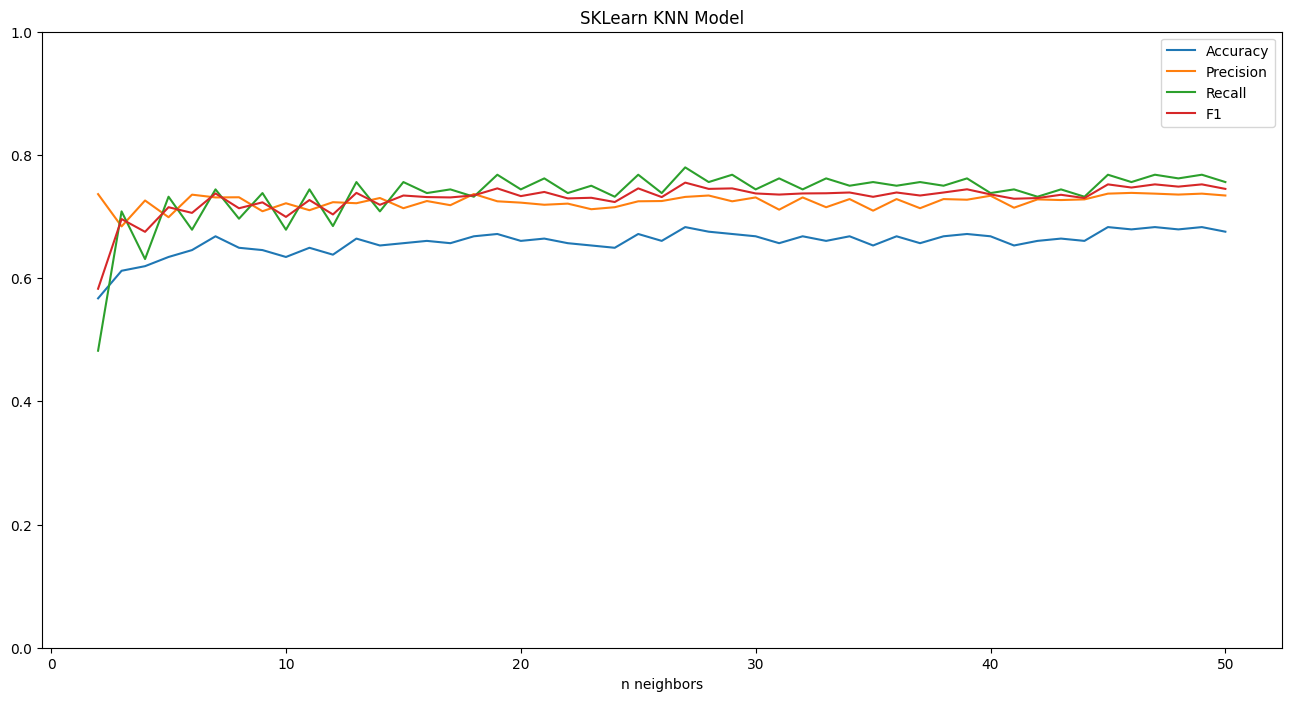

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

n_neighbors = range(2,51)
iters = 10**4
my_stats = []
skl_stats = []
for k in n_neighbors:
  model = KNN(k)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)

  my_stats.append(analyze(Y_pred, Y_test))

  model = KNeighborsClassifier(n_neighbors=k)
  model.fit(X_train, Y_train)
  Y_pred = model.predict(X_test)

  skl_stats.append(analyze(Y_pred, Y_test))

stats = np.array(my_stats)
stats_plot(stats, n_neighbors, title='My KNN Model', xlabel='n neighbors')

stats = np.array(skl_stats)
stats_plot(stats, n_neighbors, title='SKLearn KNN Model', xlabel='n neighbors')

Sabe-se lá como, de algum modo o modelo desenvolvido por mim parece ter uma quase imperceptivel vantagem sobre o modelo SKLearn. Minha suspeita cai no tratamento de empates, ou no uso de modelos não euclidianos para a distancia. Note porém que o modelo SKLearn consegue manter os valores de recall e precisão mais proximos do que o modelo implementado. No geral, os resultados são proximos.

Mais curioso é o qual superior é a performance quando analizado apenas dois vizinhos, com todas as metricas exceto precisão se encontrando abaixa de 60% no modelo SKLearn, enquanto todas sem exceção estavam acima no modelo implementado.

<ipython-input-11-8ee853da4488>:30: RuntimeWarning: Mean of empty slice.
  new_centroids = [X[labels == k].mean(axis=0) for k in range(self.n_clusters)]
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


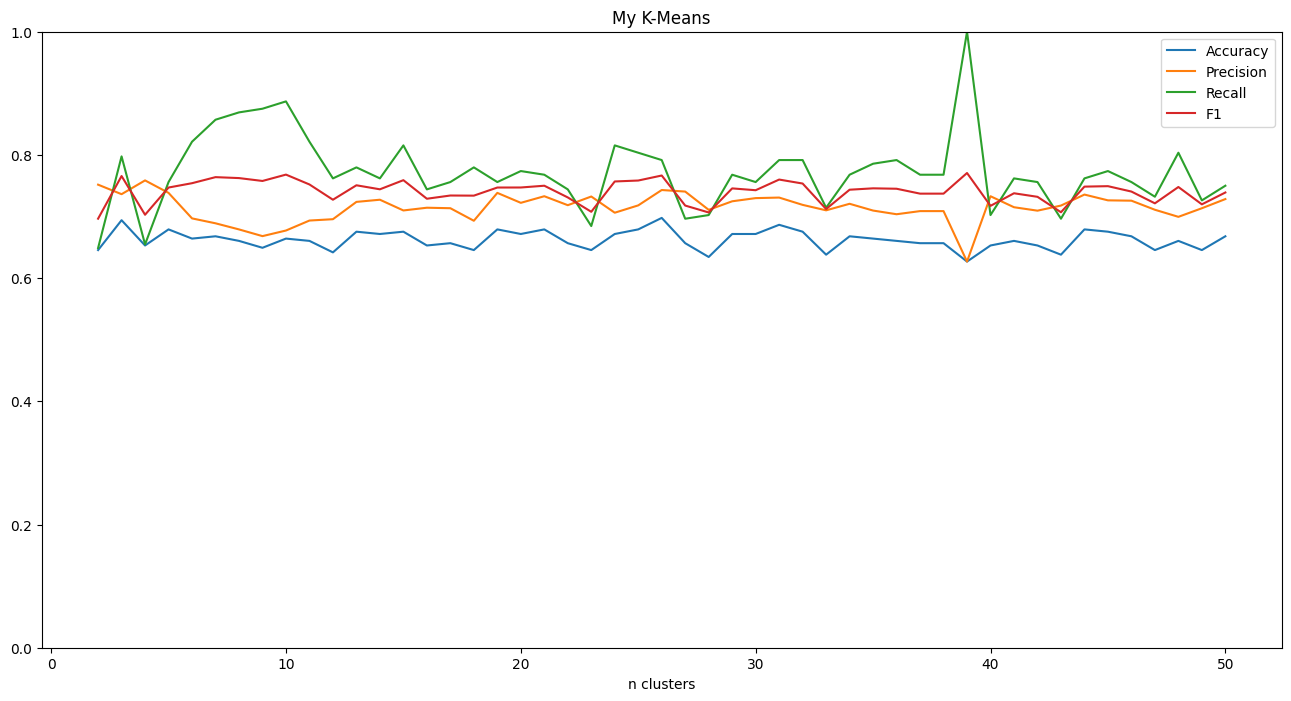

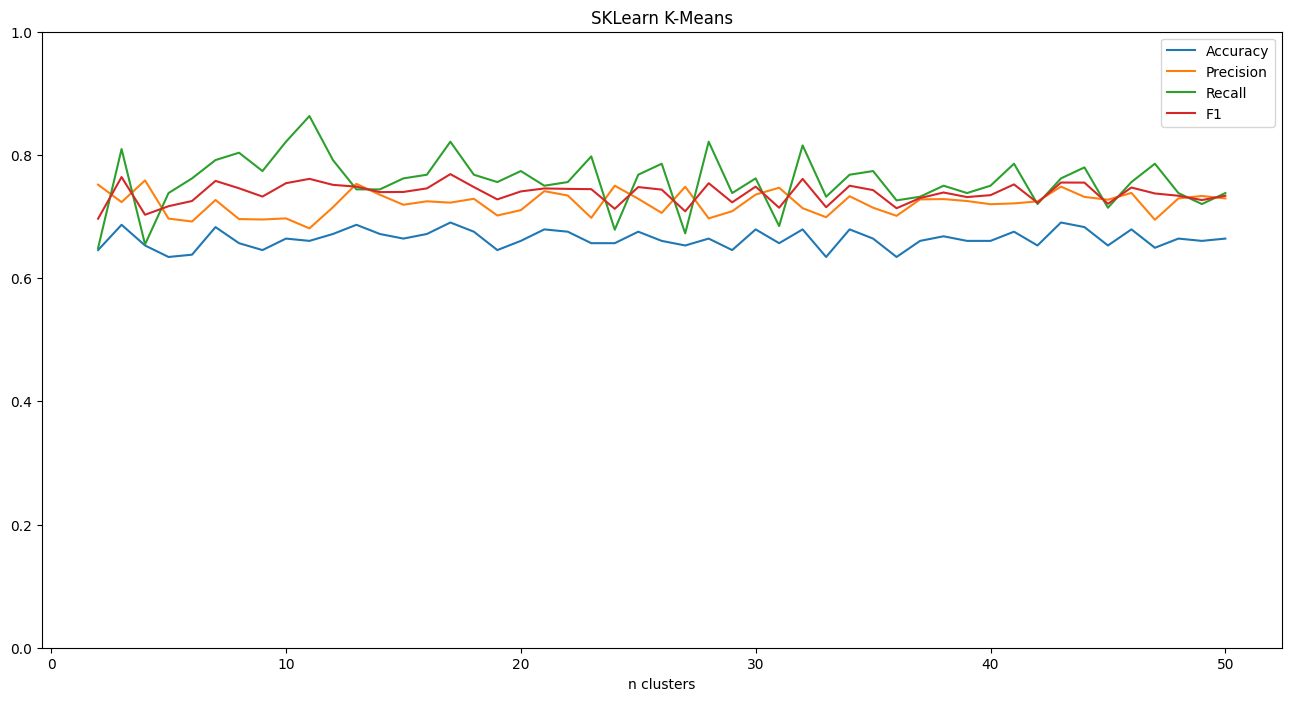

In [ ]:
from sklearn.cluster import KMeans as KMeansSKL

n_clusters = range(2,51)
iters = 10**4
my_stats = []
skl_stats = []
for k in n_clusters:
  model = KMeans(k, max_iters=iters)
  model.fit(X_train)
  labels = model.predict(X_train)
  mapped_labels = map_labels_to_Y(labels, Y_train)
  labels_test = model.predict(X_test)
  Y_pred = np.array([mapped_labels[k] for k in labels_test])

  my_stats.append(analyze(Y_pred, Y_test))

  model = KMeansSKL(k, n_init=1, max_iter=iters)
  model.fit(X_train)
  labels = model.predict(X_train)
  mapped_labels = map_labels_to_Y(labels, Y_train)
  labels_test = model.predict(X_test)
  Y_pred = np.array([mapped_labels[k] for k in labels_test])

  skl_stats.append(analyze(Y_pred, Y_test))

stats = np.array(my_stats)
stats_plot(stats, n_clusters, title='My K-Means', xlabel='n clusters')

stats = np.array(skl_stats)
stats_plot(stats, n_clusters, title='SKLearn K-Means', xlabel='n clusters')

Vemos que a performance dos dois modelos é muito semelhante, com quase todos os valores se mantendo entre 60% e 80%, salvo alguns casos onde o recall ultrapassa essa marca em ambos os modelos e em numero de clusters! proximos entre si.

Notamos porem que nosso modelo ainda se sobressai ligeiramente, que se torna evidente em casos extremos, como nos 50 clusters, quando o recall do nosso modelo consegue atingir extremos positivos maiores, sacrificando um pouco de precisão por um recall maior.